# Model optimisation

GPR models are hyper-parameterised by their kernel and noise level. In simple 1D cases, it is often easy to identify when these are leading to inappropriate model fits, but in higher dimensions this can be more difficult.

Below, we explore how to use the `mini-gpr` package to automatically find good hyper-parameters for a GPR model.

We begin with some samples from a toy 1D system, and fit a GPR model with some poorly chosen hyper-parameters:

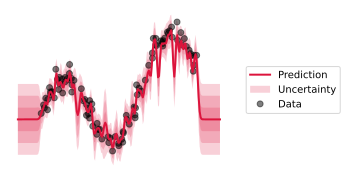

In [1]:
from mini_gpr.kernels import RBF
from mini_gpr.models import GPR
from mini_gpr.tutorials import sample_toy_1d_system
from mini_gpr.viz import show_model_predictions

x_train, y_train = sample_toy_1d_system(n=100)
model = GPR(kernel=RBF(sigma=0.1, scale=0.3), noise=0.1)
model.fit(x_train, y_train)
show_model_predictions(model, x_train, y_train)

In [2]:
model

GPR(kernel=RBF(sigma=1.00e-01, scale=3.00e-01), noise=1.00e-01)

In [3]:
model.kernel.params

{'sigma': 0.1, 'scale': 0.3}

One measure of the quality of a model's fit can be obtained by evaluating some error metric on a hold-out validation set:


In [ ]:
from mini_gpr.opt import validation_set_mse

x_val, y_val = sample_toy_1d_system(n=50, seed=1234)
validation_error_metric = validation_set_mse(x_val, y_val)
round(validation_error_metric(model), 5)

0.06873

`mini-gpr` provides the ``optimise_model`` function for optimising model (hyper-)parameters with respect to some objective function - let's use the validation set MSE as our objective:

In [5]:
from mini_gpr.opt import optimise_model

validated_model = optimise_model(
    model,
    validation_error_metric,
    x_train,
    y_train,
    optimise_noise=True,
)
validated_model

GPR(kernel=RBF(sigma=8.96e-01, scale=3.60e-01), noise=4.95e-03)

We can see that this has improved the model's fit, both by observing that the validation set MSE is lower:

In [6]:
validation_error_metric(validated_model)

0.042741757064687566

... and that the model's predictions now appear to be a better fit:

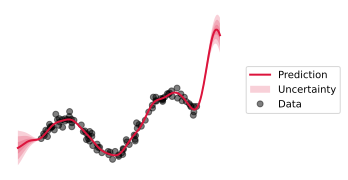

In [7]:
show_model_predictions(validated_model, x_train, y_train)

There are still some issues here, however. In particular the model is making strongly divergent predictions outside the range of the training data, and is also predicting ~0 uncertainty in regions where there is clearly some noise in the data.

We could circumvent the uncertainty prediction issues by explicitly setting the model's noise level and not optimising it (`optimise_model(..., optimise_noise=False)`). A more general approach is available to us, however, by optimising the model's log-likelihood.

The log-likelihood of the model provides a measure of how likely the training data is under the model: maximising this value tends to lead to better generalisation. The power and beauty of GPR models is that this quantity is tractably calculated! 

Interestingly, the model generated via maximising the validation set MSE is _less likely_ than our original model:

In [8]:
model.log_likelihood

-324.8419096531017

In [9]:
validated_model.log_likelihood

-55810.9176477162

Let's now generate a third model by maximising the log-likelihood:

In [10]:
from mini_gpr.opt import maximise_log_likelihood

best_model = optimise_model(
    model,
    maximise_log_likelihood,
    x_train,
    y_train,
    optimise_noise=True,
)
best_model

GPR(kernel=RBF(sigma=2.24e+00, scale=1.46e+00), noise=1.81e-01)

As we can see, the log-likelihood is much higher here - this suggests our model is fitting not only the mean function value, but also the noise in the data:

In [11]:
best_model.log_likelihood

9.87818281432942

The validation set MSE is slightly worse...

In [12]:
validation_error_metric(best_model)

0.04424907838330639

... but clearly the model fit is now much improved, including a reliable uncertainty estimate, and more reasonable predictions outside the support of the training data:

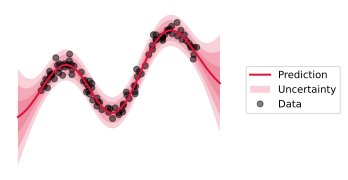

In [13]:
show_model_predictions(best_model, x_train, y_train)